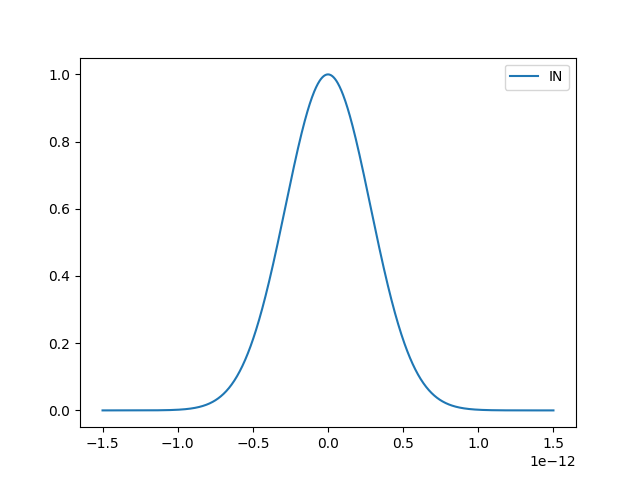

In [37]:
#region Imports
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
#endregion

#region Input Parameters
time = 100e-15                # [s]
wavelenght = 1550e-9          # [m]
wavelenght_width = 10e-9      # [m]
fibre_lenght = 10             # [m]
dispersion = 18               # [ps/(nm*km)]
c = 3e8                       # [km/s]

omega0 = (2*np.pi) / (wavelenght * 10**9)
gamma_freq =  (2*np.pi*c)/(wavelenght**2)*wavelenght_width  
gamma_time = (2*np.pi)/(2*gamma_freq)
#endregion


#region Beta
def Beta1(omega):
    return -(dispersion*wavelenght**2)/(2*np.pi*c)

def Beta2(omega):
    return (dispersion*wavelenght**2)/(2*np.pi*c)

def Beta(omega, beta1, beta2):
    return 0.5*beta2*(omega-omega0)**2 + beta1*(omega-omega0)
#endregion

#region Impuls wejściowy
time_scale = np.linspace(-1.5e-12, 1.5e-12, 1000)

def GaussSinus(time):
    return np.exp(-(time/gamma_time)**2)  * np.exp(1j*omega0*time)           # SPYTAJ GRZEGORZA CZEMU TEN SINUS TU JEST

plt.plot(time_scale, GaussSinus(time_scale), label = 'IN')
plt.legend()
plt.show()

#endregion




Powinno być 279 a jest 2790.0 [ps]
Najwyższa częstotliwość = 394942583109901.7 Hz
Próbkowanie: 1101890.0


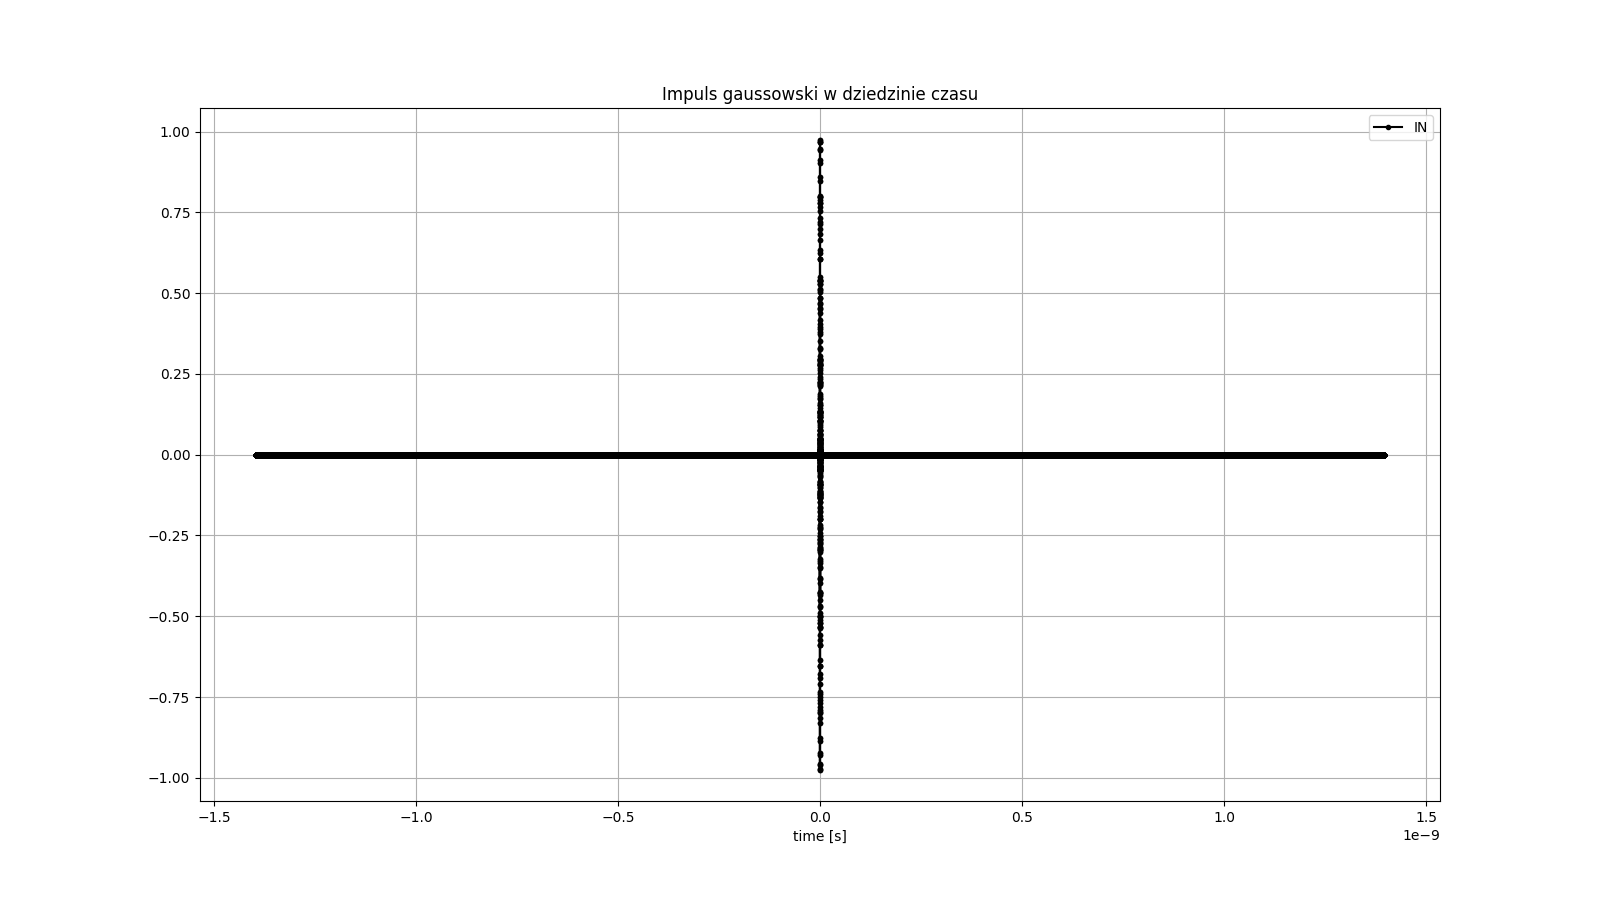

Powinno być 279 a jest 2790.0 [ps]
Najwyższa częstotliwość = 394942583109901.7 Hz
Próbkowanie: 1101890.0


array([-1.39500000e-09, -1.39499747e-09, -1.39499494e-09, ...,
        1.39499494e-09,  1.39499747e-09,  1.39500000e-09])

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft
from ipywidgets import interact

class Impuls:
    def __init__(self):
        self.time_duration = 100e-15                # [s]
        self.wavelength = 1550e-9                   # [m]
        self.wavelength_width = 10e-9               # [m]
        self.fiber_length = 10                      # [m]
        self.dispersion = 18                        # [ps/(nm*km)]
        self.c = 3e8                                # [m/s]

        self.omega0 = (2*np.pi*self.c) / (self.wavelength)                              # [rad/s]
        self.gamma_freq = (2*np.pi*self.c)/(self.wavelength**2)*self.wavelength_width   # [1/s]
        self.gamma_time = (2*np.pi)/(2*self.gamma_freq)                                 # [s]

        self.time_scale = self.TimeScale()                          # próbkowanie sprawdź; co najmniej 2 razy większa od najwższej częstości w moim widmie

        self.beta1 = -(self.dispersion*self.wavelength**2)/(2*np.pi*self.c)
        self.beta2 =  (self.dispersion*self.wavelength**2)/(2*np.pi*self.c)

    def NyquistFrequency(self):
        f0 = self.omega0 / (2*np.pi)
        highest_freq = f0 + 0.5 * self.gamma_freq
        return 2*highest_freq
    
    def TimeScale(self):
        dispersion_time = self.dispersion * self.wavelength*(10**9) * self.fiber_length*0.01        # [ps]
        print(f'Powinno być 279 a jest {dispersion_time} [ps]')
        time_axis_lenght = dispersion_time*10**(-12)                                                     # [ps]
        sampling_frequency = self.NyquistFrequency()                                                # [1/s]
        print(f'Najwyższa częstotliwość = {sampling_frequency} Hz')
        sampling = np.ceil(time_axis_lenght * sampling_frequency )
        print(f'Próbkowanie: {sampling}')                                           # liczba punktów
        time_scale = np.linspace(-0.5*time_axis_lenght, 0.5*time_axis_lenght, int(sampling))
        return time_scale

    def Beta1(self):
        return -(self.dispersion*self.wavelength**2)/(2*np.pi*self.c)

    def Beta2(self):
        return (self.dispersion*self.wavelength**2)/(2*np.pi*self.c)

    def Beta(self, omega):
        return 0.5*self.beta2*(omega-self.omega0)**2 + self.beta1*(omega-self.omega0)

    def TimeDomain(self):
        return np.exp(-(self.time_scale/self.gamma_time)**2)  * np.exp(1j*self.omega0*self.time_scale)         

    def TimeDomainPlot(self):
        plt.figure(figsize=(4,3))
        plt.plot(self.time_scale, self.TimeDomain(), label = 'IN', marker = '.', linestyle = '-', color = 'black')
        plt.xlabel('time [s]')
        plt.title('Impuls gaussowski w dziedzinie czasu')
        plt.grid()
        plt.legend()
        plt.show()

    def FrequencyDomain(self):
        frequency = fft(self.TimeDomain())
        frequencies = fftfreq(len(self.time_scale), d = self.time_scale[1] - self.time_scale[0])
        return frequency, frequencies
    
    def FrequencyDomainPlot(self):
        pulse_frequency, frequencies = self.FrequencyDomain()
        plt.figure(figsize=(16,9))
        plt.plot(frequencies, np.abs(pulse_frequency), label = 'Spectrum', color = 'black', marker = '.', linestyle = '-')
        plt.xlabel('frequency [Hz]')
        plt.title('Impuls gaussowski w dziedzinie częstotliwości')
        plt.xlim(-1.5e14, -1.3e14)
        plt.grid()
        plt.legend()
        plt.show()

    def DispersedPulse(self):
        pulse_frequency, frequencies = self.FrequencyDomain()

        omega = 2 *np.pi * frequencies
        dispersion_phase = np.exp(1j * self.Beta(omega) * self.fiber_length)

        pulse_frequency_dispersed = pulse_frequency * dispersion_phase
        pulse_time_dispersed = ifft(pulse_frequency_dispersed)

        return pulse_frequency_dispersed, pulse_time_dispersed
    
    def DispersedPlot(self):
        pulse_frequency_dispersed, pulse_time_dispersed = self.DispersedPulse() 
        pulse_freq, freqs = self.FrequencyDomain()
        plt.figure(figsize=(16,9))
        plt.plot(self.time_scale, self.TimeDomain(), color = 'black', marker = '.', linestyle = '-', label = 'Original')
        plt.plot(self.time_scale, (pulse_time_dispersed), color = 'deeppink', marker = '.', linestyle = '-', label = 'Dispersed')
        plt.title('Time Domain Dispersed')
        plt.legend()
        plt.grid()
        plt.show()
        
        plt.figure(figsize=(16,9))
        plt.plot(freqs, np.abs(pulse_freq), color = 'black', marker = '.', linestyle = '-', label = 'Original spectrum')
        plt.plot(freqs, np.abs(pulse_frequency_dispersed), color = 'deeppink', marker = '.', linestyle = '-', label = 'Dispersed spectrum')
        plt.title('Frequency Domain Dispersed')
        plt.xlim(-1.5e14, -1.3e14)
        plt.legend()        
        plt.grid()
        plt.show()

Impuls = Impuls()
Impuls.TimeDomainPlot()
# Impuls.FrequencyDomainPlot()
# Impuls.DispersedPlot()
#Impuls.NyquistFrequency()
Impuls.TimeScale()

# widmo fazy spektralnej, beta1 przesuwa w czasie i mnie nie interesuje, beta2 przesuwa fazę, czas symulacji conajmniej 10razy poszerzenie